# Evaluation using RTTM file of VAD 

We expect the VAD outputs and labels are in RTTM (Rich Transcription Time Marked)-like format.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import os
import glob
from eval_utils import *

from pyannote.core import Annotation, Segment,Timeline
from pyannote.metrics import detection

## Prepare data 

prepare ground-truth label

In [3]:
# Change
# AMI corpus
label_file = '/home/fjia/data/ami/eval/AMI/MixHeadset.test.rttm'

# CALLHOME
label_file = '/home/fjia/data/callhome/fullref.rttm'

In [4]:
df = pd.read_csv(label_file, sep=" ", delimiter=None, header=None)
df = df.rename(columns={3: "start", 4: "dur", 7: "speaker"})

label_filenames = set(df[1])

prepare predictions and audio folder

In [5]:
# Change!

# AMI corpus 
# todo add instruction to download ami labels from 
# https://github.com/pyannote/pyannote-audio/tree/master/tutorials/data_preparation/AMI
audio_folder = "/home/fjia/data/ami/ami_audio_preprocessed"
vad_frame_folder = '/home/fjia/code/res_ami_3x2_all_150-2' 
vad_txt_folder='/home/fjia/code/table_0.8-2'


# CALLHOME
audio_folder = '/home/fjia/data/callhome/r65_8_1/sid00sg1/data/'
vad_frame_folder = '/home/fjia/code/res_callhome_right_3x2_all_150-2'
vad_txt_folder='/home/fjia/code/callhome_table_0.5'

In [6]:
prediction_filenames = [os.path.basename(x).split(".txt")[0] \
                        for x in glob.glob(os.path.join(vad_txt_folder, "*.txt"))]
# Take intersection of expected filenames from label file and actual prediction filenames
filenames =  label_filenames & set(prediction_filenames)

print(f"files in either prediction or labels but not both : {label_filenames ^ set(prediction_filenames)}")

files in either prediction or labels but not both : {'iaeu'}


## construct reference and hypothesis for vad evaluation

In [7]:
def vad_construct_per_file(vad_txt_folder, df, filename):
    df_one = df[df[1]==filename].reset_index(drop = True)
    vad_file = os.path.join(vad_txt_folder, filename +'.txt')
    pred = pd.read_csv(vad_file, sep ="\t", header=None)
    
    # construct reference
    reference = Annotation(uri = filename)
    for index, row in df_one.iterrows():
        reference[Segment(row['start'],row['start'] + row['dur'])] = row['speaker']   

    # construct hypothsis
    hypothesis = Annotation(uri = filename)
    for index, row in pred.iterrows():
        if row[2] == 'speech':    
            hypothesis[Segment(row[0], row[1])] = 'Speech'
    return reference, hypothesis, df_one

$$ \text{detection error rate} = \frac{(\text{false alarm} + \text{missed detection})}{total}$$

In [8]:
metric = detection.DetectionErrorRate()
for filename in filenames:
    reference, hypothesis, df_one = vad_construct_per_file(vad_txt_folder, df, filename)
    metric(reference, hypothesis) # accumulation
        
report = metric.report(display=True)
metric.reset() # reset internal accumulator 

/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


      detection error rate    total false alarm false alarm    miss  miss
                         %                                %             %
item                                                                     
iaoq                 19.20    77.43        4.97        6.42    9.90 12.79
iapt                  6.55   109.15        4.21        3.86    2.94  2.69
iaen                  2.42    91.77        1.73        1.89    0.49  0.53
iami                 38.27    47.53        6.34       13.34   11.85 24.93
iara                  7.91    83.54        1.90        2.27    4.71  5.64
iaat                 29.09    56.83        2.05        3.61   14.48 25.48
iaoj                 17.39    62.81        2.35        3.74    8.57 13.64
iakt                 11.52    59.09        5.67        9.60    1.14  1.93
iarr                  8.07    62.85        1.51        2.40    3.56  5.66
iaim                  7.53    55.76        3.16        5.67    1.04  1.87
iakj                  5.05    77.63   

In [9]:
report.columns

MultiIndex([('detection error rate', '%'),
            (               'total',  ''),
            (         'false alarm',  ''),
            (         'false alarm', '%'),
            (                'miss',  ''),
            (                'miss', '%')],
           )

In [10]:
report.iloc[[-1]]

detection error rate      total false alarm                miss  \
                         %                                %             
item                                                                    
TOTAL            14.413953  55679.742     3556.42  6.387278  4469.232   

                 
              %  
item             
TOTAL  8.026675

save result to csv

In [11]:
report.to_csv("result.csv")

Let's see an example. 

In [12]:
filename = 'IS1009a.Mix-Headset'
filename = 'iabx'

reference, hypothesis, df_one= vad_construct_per_file(vad_txt_folder, df, filename)

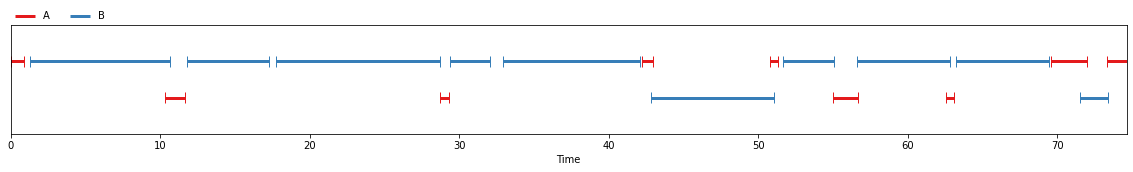

In [13]:
reference

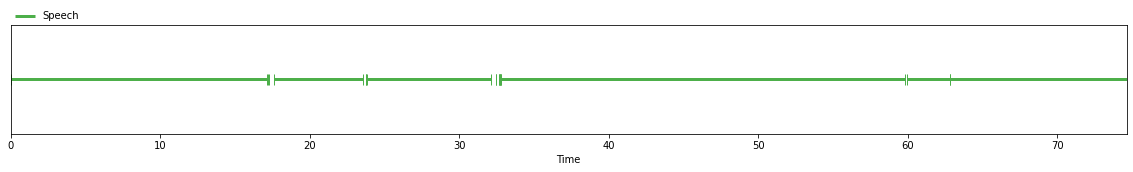

In [14]:
hypothesis

## Visualization for VAD results

/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/display.py:845: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/display.py:845: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


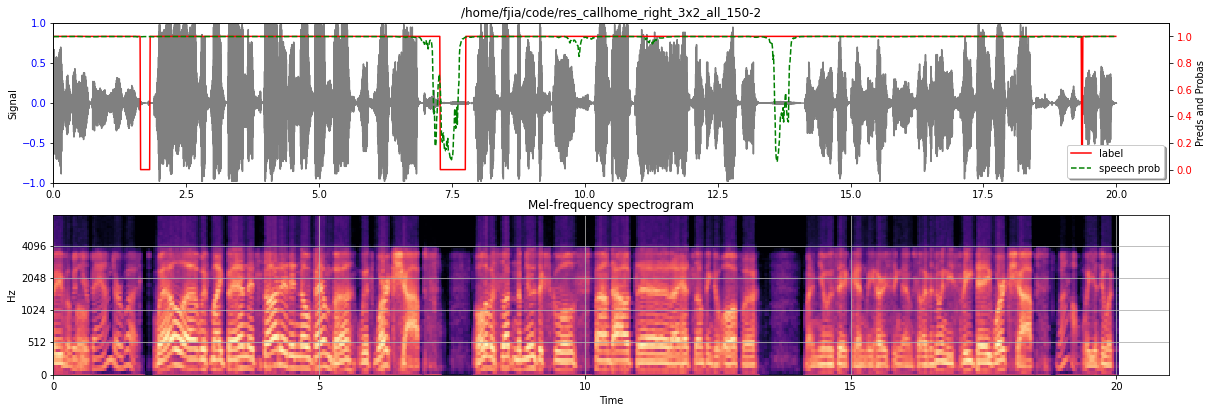

In [15]:
frame_file = filename + ".frame"

frame_folders = [vad_frame_folder, ] # add more folder of predictions to compare each other

d = {}
for i in frame_folders:
    frame = np.loadtxt(os.path.join(i, frame_file))
    d[i] = frame
    
df_eval = pd.DataFrame(data=d)

filepath = os.path.join(audio_folder, filename+'.wav')
play(df_eval, df_one, filepath=filepath, offset=10, duration=20) 